In [63]:
# Імпортуємо бібліотеки
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os
import cv2

In [65]:
# Функція для завантаження зображень з папок
def load_images_from_folder(folder_path):
    images = []
    labels = []
    label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}
    for emotion, label in label_map.items():
        emotion_folder = os.path.join(folder_path, emotion)
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Чорно-біле зображення
            img = cv2.resize(img, (48, 48))  # Зміна розміру до 48x48
            images.append(img / 255.0)  # Масштабування значень до [0, 1]
            labels.append(label)
    return np.array(images), np.array(labels)

In [95]:
# Завантаження тренувального та тестового набору даних (FER2013)
train_folder = 'archive/train'
test_folder = 'archive/test'
x_train, y_train = load_images_from_folder(train_folder)
x_test, y_test = load_images_from_folder(test_folder)

# Додавання розмірності каналу до зображень (для чорно-білих зображень)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Початкова вибірка даних
initial_training_size = 2500
train_indices = random.sample(range(len(x_train)), initial_training_size)
x_initial_train = x_train[train_indices]
y_initial_train = y_train[train_indices]

In [97]:
# Створення моделі згорткової нейронної мережі для класифікації емоцій
def create_emotion_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))  # 7 класів емоцій
    
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [99]:
# Ініціалізація моделі
model = create_emotion_model()

# Функція для тренування моделі
def train_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, verbose=2)

# Функція для оцінки моделі
def evaluate_model(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f'Accuracy: {test_acc * 100}%')
    return test_acc * 100

D:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
# Початкове навчання моделі
print("Початкове навчання моделі...")
train_model(model, x_initial_train, y_initial_train, epochs=10)
initial_accuracy = evaluate_model(model, x_test, y_test)

Початкове навчання моделі...
Epoch 1/10
71/71 - 4s - 59ms/step - accuracy: 0.2440 - loss: 1.8506 - val_accuracy: 0.2240 - val_loss: 1.8412
Epoch 2/10
71/71 - 3s - 35ms/step - accuracy: 0.2489 - loss: 1.8380 - val_accuracy: 0.2440 - val_loss: 1.8326
Epoch 3/10
71/71 - 3s - 37ms/step - accuracy: 0.2538 - loss: 1.8077 - val_accuracy: 0.2880 - val_loss: 1.7826
Epoch 4/10
71/71 - 3s - 38ms/step - accuracy: 0.2880 - loss: 1.7422 - val_accuracy: 0.3360 - val_loss: 1.6893
Epoch 5/10
71/71 - 3s - 38ms/step - accuracy: 0.3484 - loss: 1.6541 - val_accuracy: 0.3400 - val_loss: 1.7050
Epoch 6/10
71/71 - 2s - 35ms/step - accuracy: 0.3813 - loss: 1.5904 - val_accuracy: 0.3440 - val_loss: 1.7632
Epoch 7/10
71/71 - 2s - 35ms/step - accuracy: 0.4307 - loss: 1.5047 - val_accuracy: 0.3280 - val_loss: 1.8077
Epoch 8/10
71/71 - 2s - 35ms/step - accuracy: 0.4533 - loss: 1.4524 - val_accuracy: 0.3240 - val_loss: 1.8400
Epoch 9/10
71/71 - 3s - 35ms/step - accuracy: 0.4920 - loss: 1.3664 - val_accuracy: 0.3600 

In [103]:
# Активне навчання
active_iterations = 15
selection_size = 400
accuracies_entropy = [initial_accuracy]

for iteration in range(active_iterations):
    # Вибірка за найбільшою ентропією
    predictions = model.predict(x_train)
    entropies = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)  # Обчислення ентропії
    unlabeled_indices = [i for i in range(len(x_train)) if i not in train_indices]
    unlabeled_entropies = entropies[unlabeled_indices]
    selected_indices_entropy = np.argsort(unlabeled_entropies)[-selection_size:]
    
    # Оновлення індексів навчальної вибірки
    train_indices.extend([unlabeled_indices[i] for i in selected_indices_entropy])
    x_initial_train = x_train[train_indices]
    y_initial_train = y_train[train_indices]
    
    # Перенавчання моделі
    print(f"Ітерація {iteration + 1} (ентропія), Кількість навчальних даних: {len(train_indices)}")
    train_model(model, x_initial_train, y_initial_train, epochs=2)
    accuracy = evaluate_model(model, x_test, y_test)
    accuracies_entropy.append(accuracy)

898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
Ітерація 1 (ентропія), Кількість навчальних даних: 2900
Epoch 1/2
82/82 - 3s - 36ms/step - accuracy: 0.5253 - loss: 1.2761 - val_accuracy: 0.2655 - val_loss: 1.8381
Epoch 2/2
82/82 - 3s - 38ms/step - accuracy: 0.5590 - loss: 1.1977 - val_accuracy: 0.2414 - val_loss: 1.8330
225/225 - 3s - 12ms/step - accuracy: 0.3975 - loss: 1.6190
Accuracy: 39.746448397636414%
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
Ітерація 2 (ентропія), Кількість навчальних даних: 3300
Epoch 1/2
93/93 - 4s - 39ms/step - accuracy: 0.5795 - loss: 1.1654 - val_accuracy: 0.3545 - val_loss: 1.7124
Epoch 2/2
93/93 - 3s - 36ms/step - accuracy: 0.6178 - loss: 1.0658 - val_accuracy: 0.3485 - val_loss: 1.6685
225/225 - 2s - 11ms/step - accuracy: 0.4220 - loss: 1.6975
Accuracy: 42.198383808135986%
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
Ітерація 3 (ентропія), Кількість навчальних даних: 3700
Epoch 1/2
105/105 - 4s - 35ms/step - accuracy: 0.6246 - loss: 1.0328 - val_accuracy: 0.20

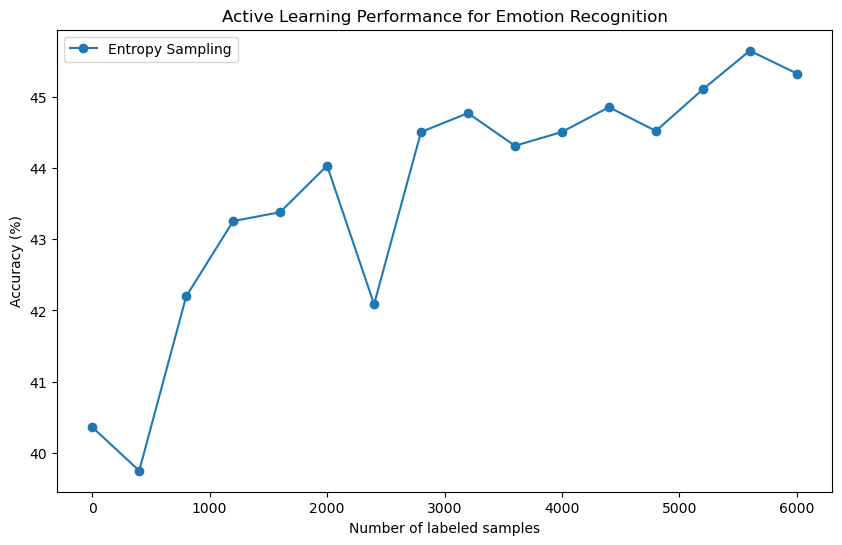

In [105]:
# Візуалізація точності моделі для активного навчання
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(accuracies_entropy) * selection_size, selection_size), accuracies_entropy, marker='o', label='Entropy Sampling')
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning Performance for Emotion Recognition')
plt.legend()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


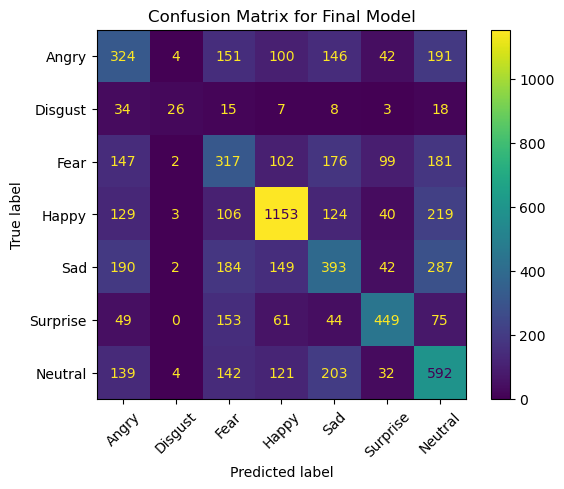

In [107]:
# Створення матриці помилок для фінальної моделі
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix for Final Model')
plt.show()